In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
csdv_df = pd.read_csv('customer_segmentation.csv')

In [13]:
csdv_df.head(100)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,...,seller_id,shipping_limit_date,price,freight_value,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_category_name_english
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,belo horizonte,SP,perfumaria,29,178,perfumery
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,delivered,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,credit_card,5,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-13 14:31:29,116.9,18.92,belo horizonte,SP,perfumaria,29,178,perfumery
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,delivered,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-13 03:45:45,118.7,9.34,belo horizonte,SP,perfumaria,29,178,perfumery
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,c1f93f3729018caa75319804a59481db,d44c886d9d7a76bdcd3df6adccde822d,delivered,2018-06-17 02:25:02,2018-06-17 02:35:11,2018-06-18 14:18:00,2018-06-22 00:43:33,2018-07-12 00:00:00,credit_card,1,...,d3f39f05462b79a4562d35893a28f159,2018-06-21 02:35:11,29.9,12.87,mococa,SP,perfumaria,48,1037,perfumery
96,4c832b5c447f450474f8470737f7e580,532f9ca016bff3198570d8eb8aa6b00e,delivered,2018-06-05 22:54:28,2018-06-05 23:12:42,2018-06-06 14:07:00,2018-06-08 18:14:19,2018-07-11 00:00:00,credit_card,1,...,d3f39f05462b79a4562d35893a28f159,2018-06-13 23:12:42,29.9,12.79,mococa,SP,perfumaria,48,1037,perfumery
97,4c832b5c447f450474f8470737f7e580,532f9ca016bff3198570d8eb8aa6b00e,delivered,2018-06-05 22:54:28,2018-06-05 23:12:42,2018-06-06 14:07:00,2018-06-08 18:14:19,2018-07-11 00:00:00,credit_card,1,...,d3f39f05462b79a4562d35893a28f159,2018-06-13 23:12:42,29.9,12.79,mococa,SP,perfumaria,48,1037,perfumery
98,55af89bd3634844abc96b00c4caa76a5,43e2c04ed657fada56adb13d4318760a,delivered,2018-07-29 13:48:04,2018-07-30 09:31:10,2018-08-06 16:47:00,2018-08-10 17:56:54,2018-08-24 00:00:00,credit_card,4,...,7d13fca15225358621be4086e1eb0964,2018-08-07 08:30:20,110.0,18.87,ribeirao preto,SP,perfumaria,39,613,perfumery


Io toglierei product_category_name, product_name_length e product_description_length (non so se altro)

In [14]:
corr = csdv_df.corr()

This evaluates the correlation only among numerical variables

<AxesSubplot:>

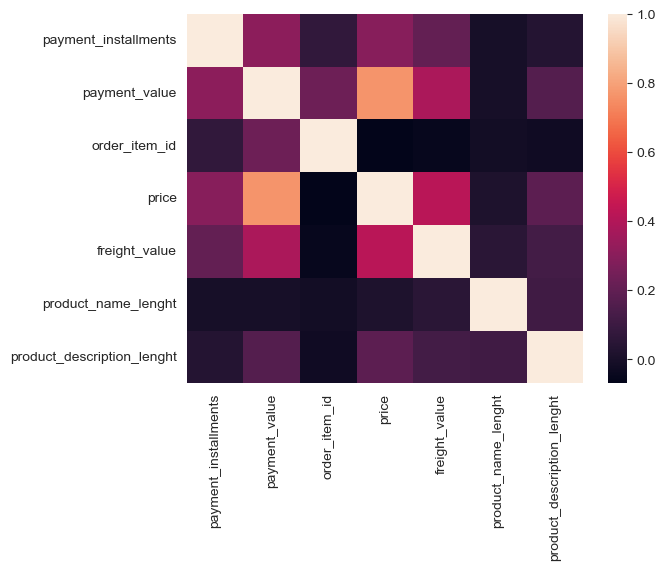

In [15]:
sns.heatmap(corr)

In [16]:
print("Dataset info:")
display(csdv_df.info())
print()
print("Dataset shape:")
display(csdv_df.shape)
print()
display(csdv_df.describe())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13801 entries, 0 to 13800
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       13801 non-null  object 
 1   customer_id                    13801 non-null  object 
 2   order_status                   13801 non-null  object 
 3   order_purchase_timestamp       13801 non-null  object 
 4   order_approved_at              13801 non-null  object 
 5   order_delivered_carrier_date   13801 non-null  object 
 6   order_delivered_customer_date  13801 non-null  object 
 7   order_estimated_delivery_date  13801 non-null  object 
 8   payment_type                   13801 non-null  object 
 9   payment_installments           13801 non-null  int64  
 10  payment_value                  13801 non-null  float64
 11  customer_unique_id             13801 non-null  object 
 12  customer_city                  1

None


Dataset shape:


(13801, 26)

,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,3.014637,194.349691,1.230491,130.947103,21.938168,49.300703,814.330411
std,2.801721,294.854258,0.737495,210.712421,18.567013,9.759529,648.790194
min,1.000000,0.050000,1.000000,0.850000,0.000000,8.000000,4.000000
25%,1.000000,66.750000,1.000000,40.000000,12.870000,43.000000,366.000000
50%,2.000000,120.290000,1.000000,79.000000,18.230000,52.000000,631.000000
75%,4.000000,206.780000,1.000000,139.000000,23.310000,57.000000,1030.000000
max,20.000000,7274.880000,13.000000,4590.000000,375.280000,69.000000,3985.000000
